#  Прогнозирование заказов такси

Компания  по предоставлению услуг такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Цель проекта:
* Сформировать модель, которая будет эффективно прогнозировать количество заказов такси на следующий час. 
* Значение метрики RMSE на тестовой выборке должно быть не больше 48.


План проекта:

1. Загрузка данных и ресемплирование по одному часу
2. Анализ данных
3. Обучение разных моделей с различными гиперпараметрами
4. Проверка моделей на тестовой выборке
5. Проверка на адекватность
6. Итоговый вывод


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`

## Подготовка

### Загрузка и изучение данных

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error

from IPython.display import display


In [3]:
RANDOM_STATE = 12345

In [4]:
try:
    data = pd.read_csv('/datasets/taxi.csv')
except:
    data = pd.read_csv('/content/taxi.csv')

Первые 5 строк:


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32



Последние 5 строк:


,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53



Общая информация по таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None

Статистика по таблице:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000



Всего явных дубликатов: 0

Количество пропусков:


datetime      0
num_orders    0
dtype: int64

Нулевые значения:
datetime      0
num_orders    0
dtype: int64
Гистограммы распределения признаков:


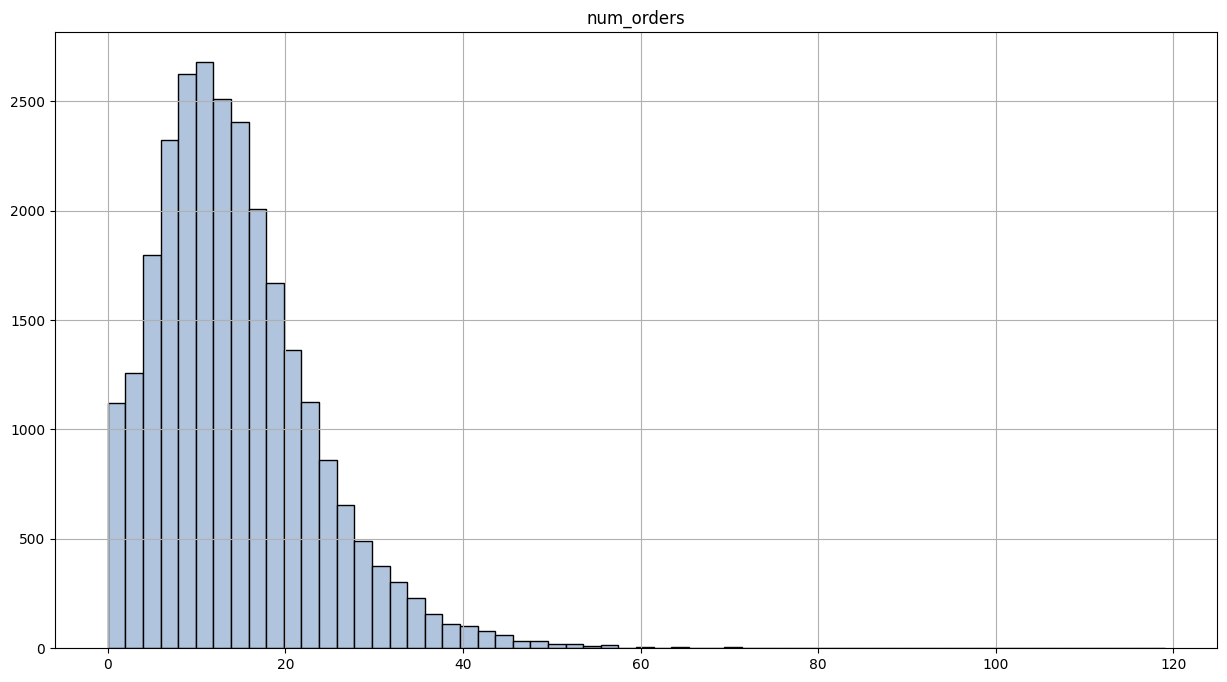

In [5]:
for _ in [data]:
    print('Первые 5 строк:')
    display(_.head())
    print()
    print('Последние 5 строк:')
    display(_.tail())
    print()
    print('Общая информация по таблице:')
    print()
    print(_.info())
    print()
    print('Статистика по таблице:')
    display(_.describe())
    print()
    print('Всего явных дубликатов:', _.duplicated().sum())
    print()
    print('Количество пропусков:')
    display(_.isna().sum())
    print('Нулевые значения:')
    print(_.isnull().sum())
    print('Гистограммы распределения признаков:')
    data.hist(figsize=(15, 8), bins=60, edgecolor='Black', color='LightSteelBlue')

### Предобработка данных

#### Изменение типа данных

In [6]:
data['datetime'] = data['datetime'].astype('datetime64')
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB
None


#### Установка индекса таблицы

In [7]:
data=data.set_index('datetime')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
print(data.index.is_monotonic)

True


<ipython-input-8-32a0fbcdd322>:1: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  print(data.index.is_monotonic)


#### Ресемплирование данных по одному часу

Построим график временного ряда:

<Axes: xlabel='datetime'>

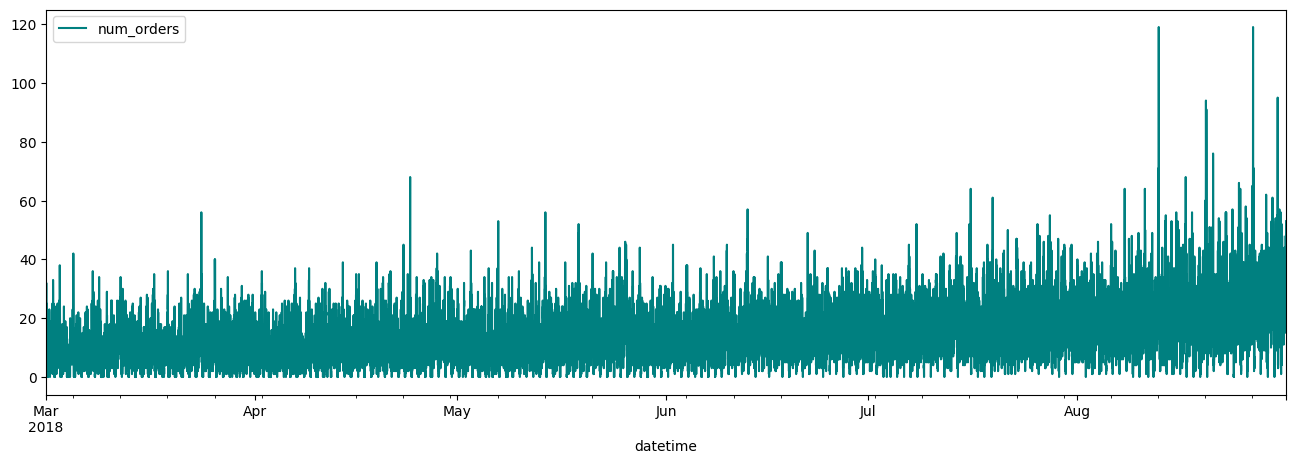

In [9]:
data.plot(figsize=(16,5),  color='teal')


In [10]:
data = data.resample('1H').sum()

<Axes: xlabel='datetime'>

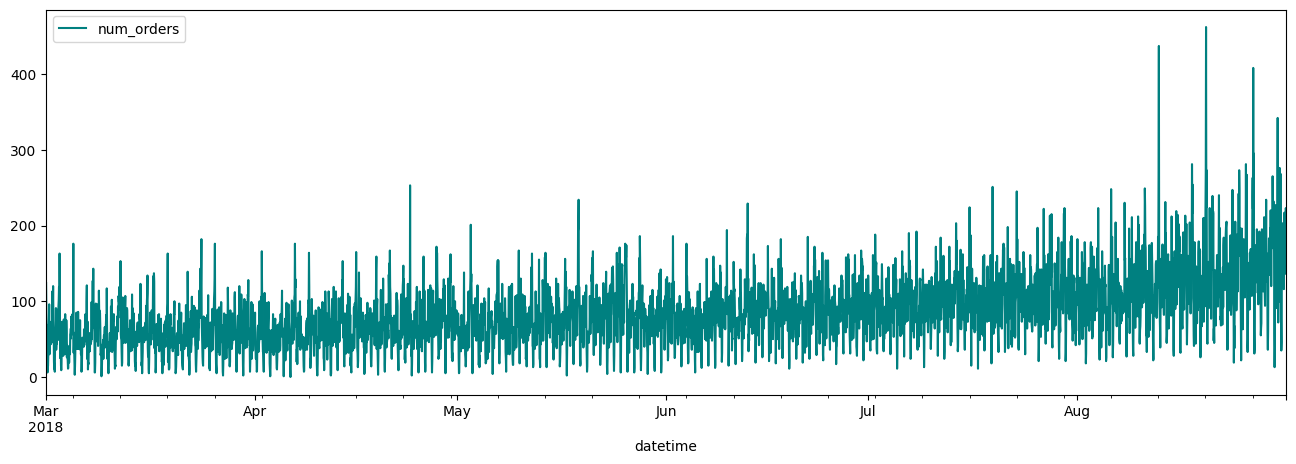

In [11]:
data.plot(figsize=(16,5),  color='teal')


Посмотрим на график по последнему месяцу (за август 2018):

In [12]:
data_08 = data['2018-08':]

<Axes: xlabel='datetime'>

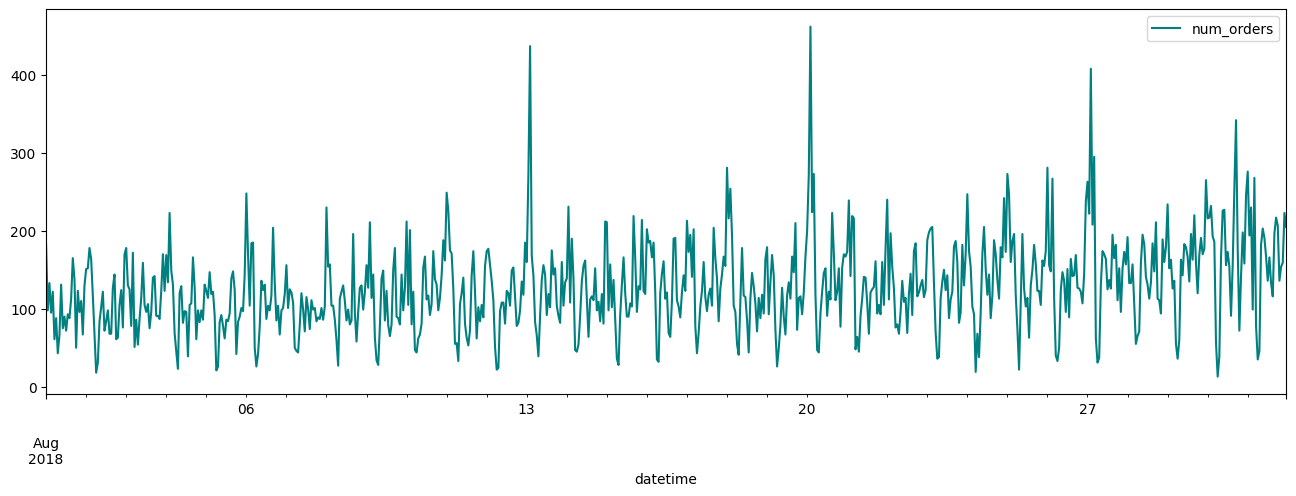

In [13]:
data_08.plot(figsize=(16,5),  color='teal')


Посмотрим график за последнюю полную неделю августа(с понедельника-воскресенье):

<Axes: xlabel='datetime'>

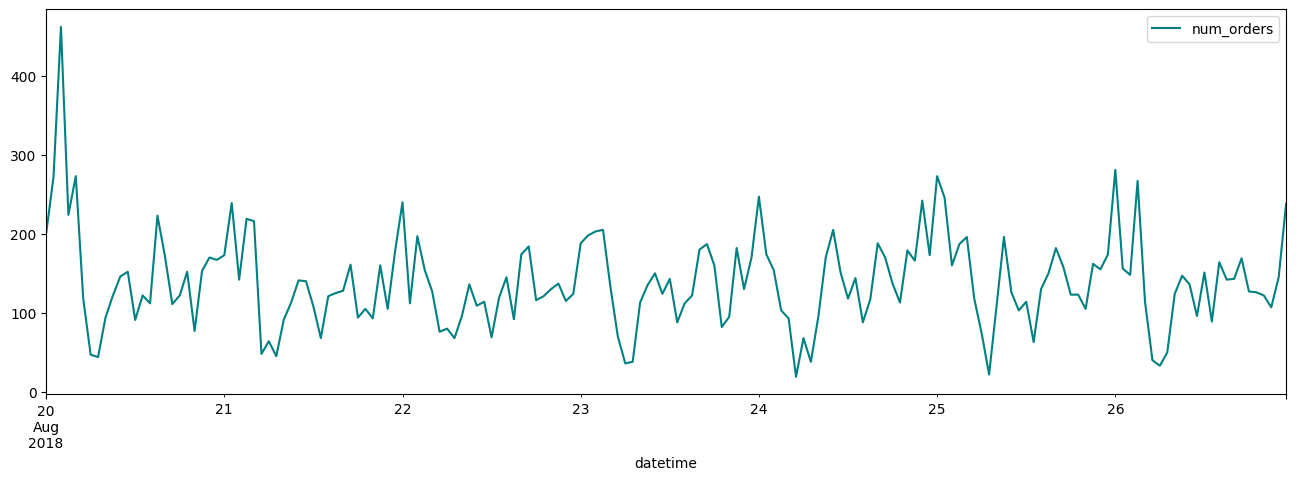

In [14]:
data_08_4w = data['2018-08-20':'2018-08-26']
data_08_4w.plot(figsize=(16,5),  color='teal')

### Вывод:
1. Данные представляют собой информацию о заказах такси в аэропортах в период с 1 марта 2018г по 31 августа 2018г, всего 26496 строк
2. Данные расположены в хронологическом порядке
3. Пропуски, нулевые значения и дубликаты не обнаружены
4. Интересны выбросы в целевом признаке - но их удалять не будем, т к во временном ряду не должно быть пробелов, возможно большое количество заказов связано с каким-нибудь коллапсом с задержкой рейсов
5. Изменили тип данных в колонке 'datetime' с object на datetime64
6. Установили индекс таблицы равным колонке 'datetime'
7. Выполнили ресемплирование данных по одному часу


## Анализ

### Тренды, сезонности и остатки

Сформируем тренды, сезонности и остатки по всему периоду, за август по дням и за последнюю полную неделю августа(с понедельника-воскресенье):

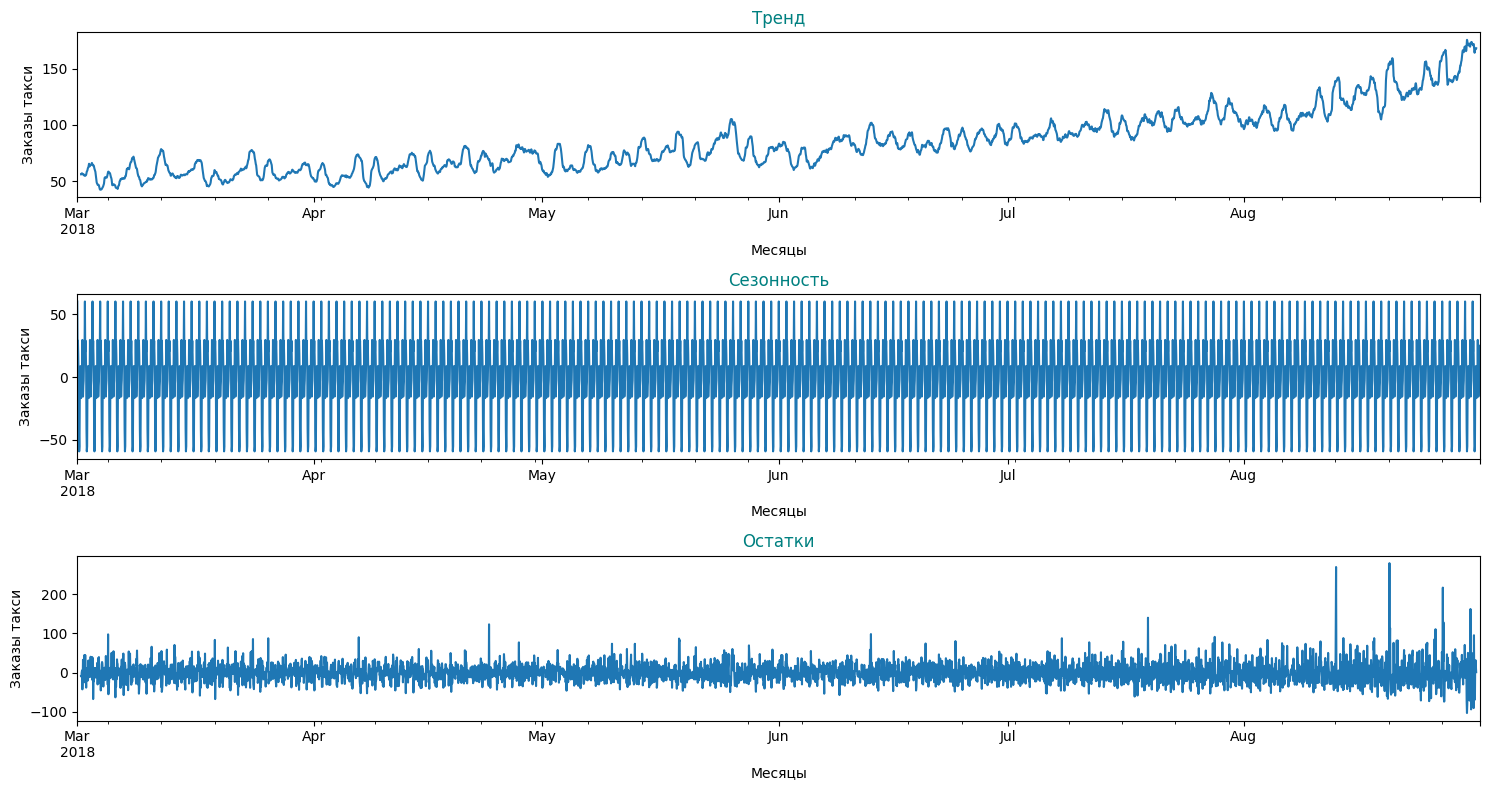

In [15]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд', color='teal')
plt.xlabel('Месяцы')
plt.ylabel('Заказы такси')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность', color='teal')
plt.xlabel('Месяцы')
plt.ylabel('Заказы такси')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки', color='teal')
plt.xlabel('Месяцы')
plt.ylabel('Заказы такси')
plt.tight_layout()


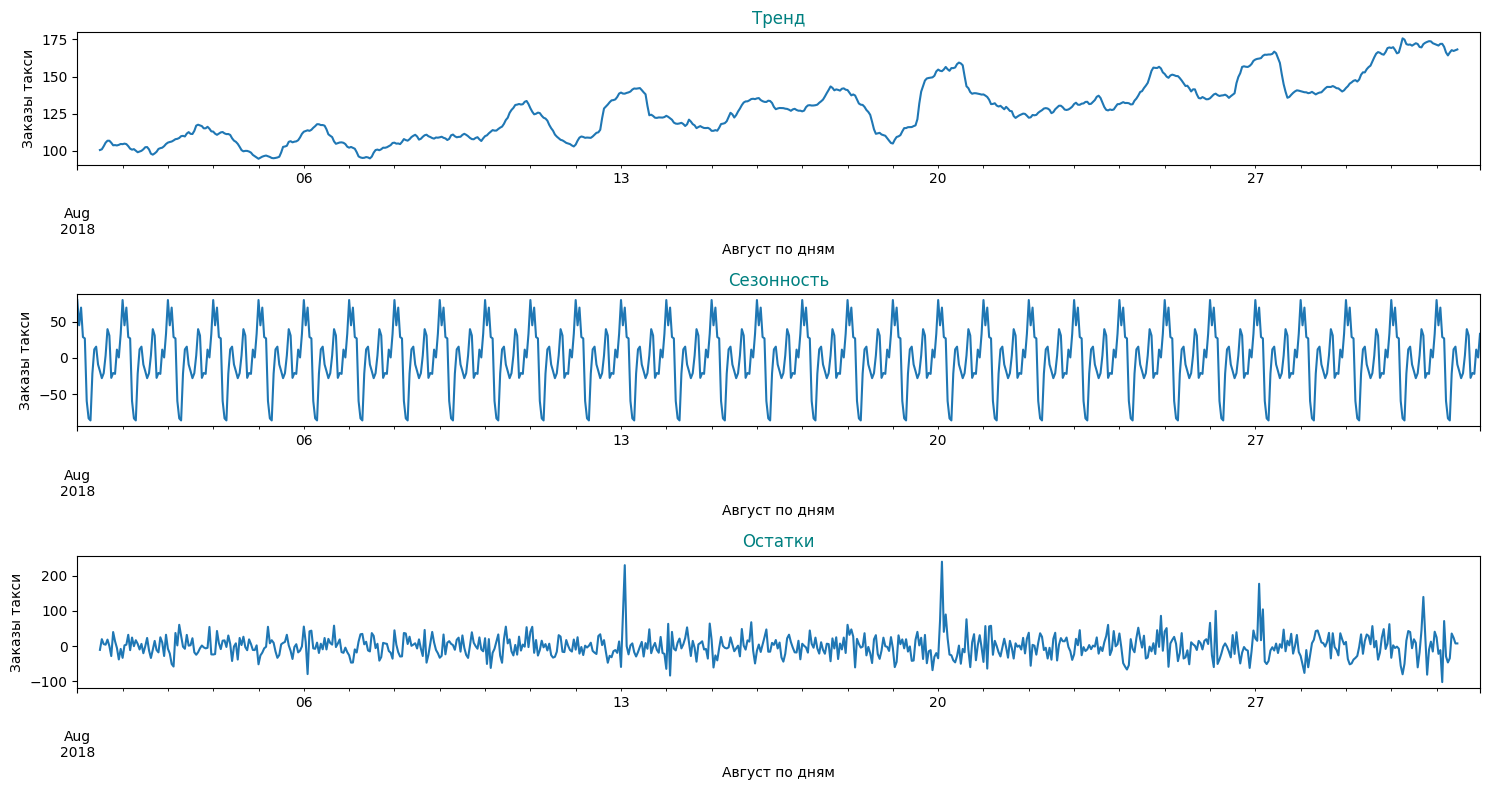

In [16]:
decomposed_08 = seasonal_decompose(data_08)
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed_08.trend.plot(ax=plt.gca())
plt.title('Тренд', color='teal')
plt.xlabel('Август по дням')
plt.ylabel('Заказы такси')
plt.subplot(312)
decomposed_08.seasonal.plot(ax=plt.gca())
plt.title('Сезонность', color='teal')
plt.xlabel('Август по дням')
plt.ylabel('Заказы такси')
plt.subplot(313)
decomposed_08.resid.plot(ax=plt.gca())
plt.title('Остатки', color='teal')
plt.xlabel('Август по дням')
plt.ylabel('Заказы такси')
plt.tight_layout()


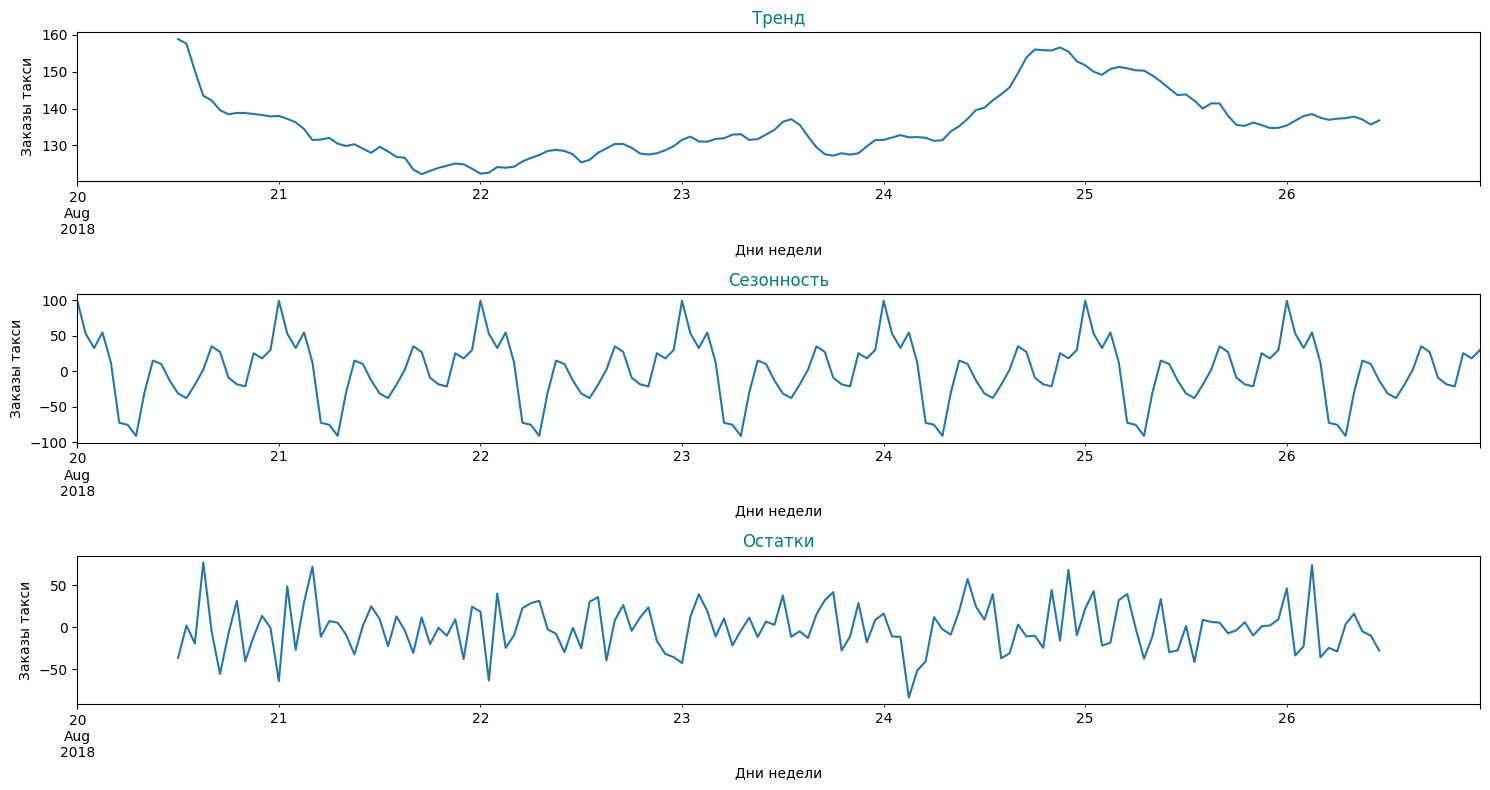

In [17]:
decomposed_08_4w = seasonal_decompose(data_08_4w)
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed_08_4w .trend.plot(ax=plt.gca())
plt.title('Тренд', color='teal')
plt.xlabel('Дни недели')
plt.ylabel('Заказы такси')
plt.subplot(312)
decomposed_08_4w .seasonal.plot(ax=plt.gca())
plt.title('Сезонность', color='teal')
plt.xlabel('Дни недели')
plt.ylabel('Заказы такси')
plt.subplot(313)
decomposed_08_4w .resid.plot(ax=plt.gca())
plt.title('Остатки', color='teal')
plt.xlabel('Дни недели')
plt.ylabel('Заказы такси')
plt.tight_layout()


Вывод:
* Выраженый рост количества заказов летом - с конца мая по конец периода, скорее всего связано с большим количеством отпусков и, соответственно, полетов
* По периоду последнего месяца количество заказов заметно растет с 20 ого числа, т е в последней трети месяца заказов больше всего
* За неделю больше всего заказов понедельник и пятницу - связано с поезками на выходные и наоборот командировками на рабочую неделю
* За день смотреть колебания нет смысла, так как в зависимости от дня недели показатели будут разные
* Сезонность - сутки, наибольшее количество заказов ранним утром и поздно вечером - связано с тем что многие предпочитают  перелеты в это время чтобы не терять день в дороге
* Т к тренд явно возрастающий ряд нельзя считать стационарным

### Скользящее среднее и скользящее стандартное отклонение

Вычислим разность временного ряда. На графике изобразим скользящее среднее и скользящее стандартное отклонение на всем периоде, за август по дням и за последнюю неделю августа

<Axes: xlabel='datetime'>

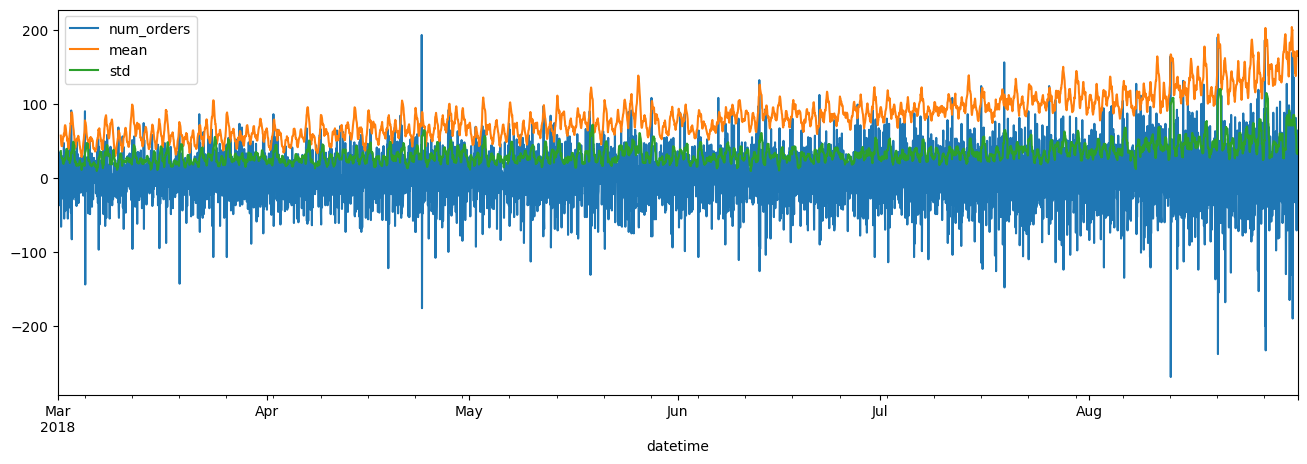

In [18]:
data_shift = data - data.shift()
data_shift['mean'] = data['num_orders'].rolling(12).mean()
data_shift['std'] = data['num_orders'].rolling(12).std()
data_shift.plot(figsize=(16,5))


<Axes: xlabel='datetime'>

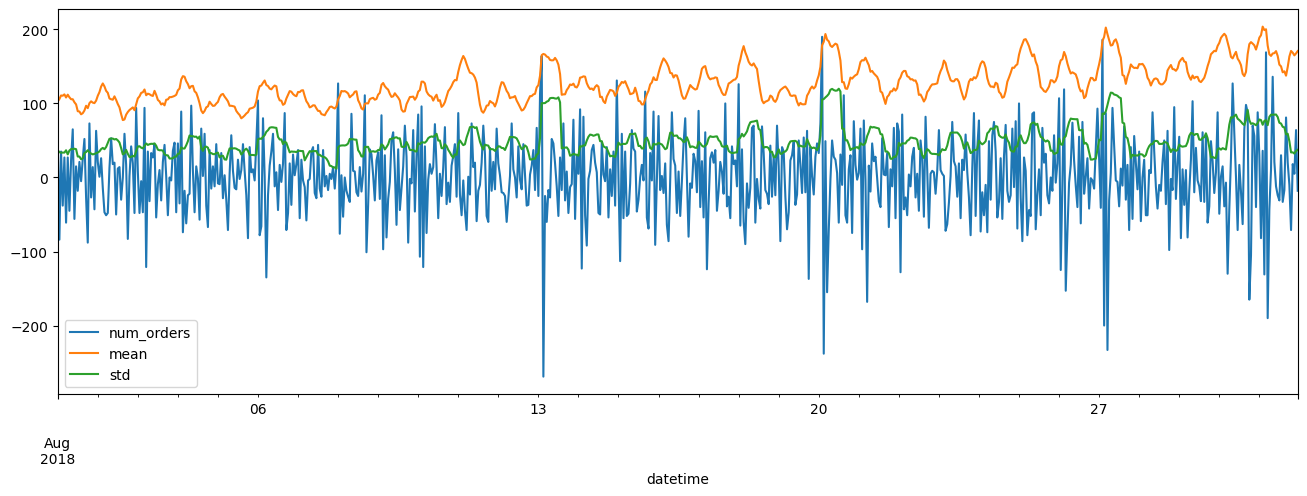

In [19]:
data_08 = data_shift['2018-08':]
data_08.plot(figsize=(16,5))


<Axes: xlabel='datetime'>

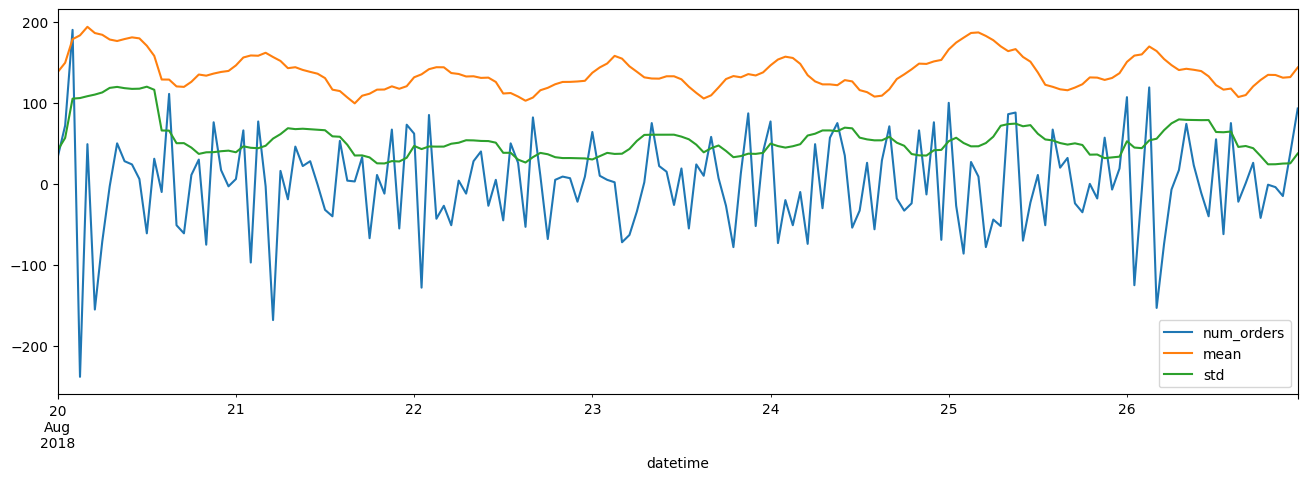

In [20]:
data_08_4w = data_shift['2018-08-20':'2018-08-26']
data_08_4w.plot(figsize=(16,5))


Ряд стал более стационарным

## Обучение

### Подготовка признаков и деление на выборки

Напишем функцию для формирования признаков. Год и месяц не будем использовать т к они не отражают нужные зависимости. Разделим данные на тренировочную и тестовую выборки в соотношении 9:1 (тестовая выборка 10% от исходных данных по условию задачи):

In [21]:
def make_features(data, max_lag, rolling_mean_size):
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(data, 24, 168)


max_lag = 24 (так как наблюдается выраженная сезонность в сутки)

rolling_mean_size = 168 (количество часов в неделю, так как наблюдается недельная сезонность)

In [22]:
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())


2018-03-01 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [24]:
train = train.dropna()
print(train.shape)
print(test.shape)

(3806, 28)
(442, 28)


In [25]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### LightGBMRegressor

In [26]:
tscv = TimeSeriesSplit(n_splits=5)


In [27]:
%%time

model_LGBMR = LGBMRegressor()
parameters = [{'num_leaves': [20, 50, 10],
               'learning_rate':[0.1, 0.3, 0.1], 'n_estimators':[30, 200, 30], 'random_state':[RANDOM_STATE]}]

model_LGBMR_selection = GridSearchCV(model_LGBMR, parameters, cv=tscv,  scoring='neg_mean_squared_error')
model_LGBMR_selection.fit(features_train, target_train)

print(model_LGBMR_selection.best_params_)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2669
[LightGBM] [Info] Number of data points in the train set: 636, number of used features: 27
[LightGBM] [Info] Start training from score 57.938679
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 1270, number of used features: 27
[LightGBM] [Info] Start training from score 61.134646
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3776
[LightGBM] [Info] Number of data points in the train set: 1904, number of used features: 27
[LightGBM] [Info] St

In [28]:
%%time

score_LGBMR = model_LGBMR_selection.best_score_
rsme_LGBMR = np.mean(-score_LGBMR)**0.5
print ('RMSE на лучшей модели LGBMRegressor:', rsme_LGBMR)

RMSE на лучшей модели LGBMRegressor: 25.269179625126228
CPU times: user 1.77 ms, sys: 0 ns, total: 1.77 ms
Wall time: 1.78 ms


### CatBoostRegressor

In [29]:
%%time

model_CBR = CatBoostRegressor()
parameters = [{'iterations': [50, 300, 50],
               'learning_rate':[0.05, 0.5, 0.1], 'depth':[2, 50, 10], 'random_state':[RANDOM_STATE]}]

model_CBR_selection = GridSearchCV(model_CBR, parameters, cv=tscv, scoring='neg_mean_squared_error')
model_CBR_selection.fit(features_train, target_train)

print(model_CBR_selection.best_params_)



Выходные данные были обрезаны до нескольких последних строк (5000).
252:	learn: 3.6193134	total: 16.7s	remaining: 3.1s
253:	learn: 3.6157622	total: 16.7s	remaining: 3.03s
254:	learn: 3.6119625	total: 16.8s	remaining: 2.96s
255:	learn: 3.5898268	total: 16.8s	remaining: 2.89s
256:	learn: 3.5657637	total: 16.8s	remaining: 2.82s
257:	learn: 3.5358715	total: 16.9s	remaining: 2.75s
258:	learn: 3.5279652	total: 16.9s	remaining: 2.68s
259:	learn: 3.5019719	total: 16.9s	remaining: 2.6s
260:	learn: 3.4991941	total: 17s	remaining: 2.54s
261:	learn: 3.4775796	total: 17s	remaining: 2.47s
262:	learn: 3.4464808	total: 17.1s	remaining: 2.4s
263:	learn: 3.4354434	total: 17.1s	remaining: 2.33s
264:	learn: 3.4208846	total: 17.1s	remaining: 2.26s
265:	learn: 3.4180987	total: 17.2s	remaining: 2.19s
266:	learn: 3.3904934	total: 17.2s	remaining: 2.13s
267:	learn: 3.3718870	total: 17.2s	remaining: 2.06s
268:	learn: 3.3517130	total: 17.3s	remaining: 1.99s
269:	learn: 3.3255903	total: 17.3s	remaining: 1.92s
270

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5703, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2303, in _fit
    train_par

2:	learn: 36.0618371	total: 185ms	remaining: 18.3s
3:	learn: 35.2269310	total: 298ms	remaining: 22s
4:	learn: 34.4133952	total: 411ms	remaining: 24.2s
5:	learn: 33.6960863	total: 527ms	remaining: 25.8s
6:	learn: 33.0572049	total: 636ms	remaining: 26.6s
7:	learn: 32.4220664	total: 745ms	remaining: 27.2s
8:	learn: 31.8322027	total: 856ms	remaining: 27.7s
9:	learn: 31.3170634	total: 966ms	remaining: 28s
10:	learn: 30.7366065	total: 1.09s	remaining: 28.5s
11:	learn: 30.2045255	total: 1.2s	remaining: 28.8s
12:	learn: 29.6925160	total: 1.34s	remaining: 29.5s
13:	learn: 29.2102743	total: 1.5s	remaining: 30.6s
14:	learn: 28.7738491	total: 1.63s	remaining: 31s
15:	learn: 28.3168003	total: 1.75s	remaining: 31.1s
16:	learn: 27.9372346	total: 1.86s	remaining: 31.1s
17:	learn: 27.4968128	total: 1.98s	remaining: 31s
18:	learn: 27.1244639	total: 2.09s	remaining: 30.9s
19:	learn: 26.7780770	total: 2.19s	remaining: 30.7s
20:	learn: 26.4236000	total: 2.3s	remaining: 30.5s
21:	learn: 26.1299633	total: 2.

In [30]:
score_CBR = model_CBR_selection.best_score_
rsme_CBR = np.mean(-score_CBR)**0.5
print ('RMSE на лучшей модели CatBoostRegressor:', rsme_CBR)

RMSE на лучшей модели CatBoostRegressor: 25.482204200244066


### LinearRegression


In [31]:
%%time

model_LR = LinearRegression()

score_LR = cross_val_score(model_LR, features_train, target_train,
                                    cv=tscv, scoring='neg_mean_squared_error')
rsme_LR =np.mean(-score_LR)**0.5
print ('RMSE на лучшей модели LinearRegression:', rsme_LR)


RMSE на лучшей модели LinearRegression: 27.29011275484426
CPU times: user 60.6 ms, sys: 35.9 ms, total: 96.5 ms
Wall time: 53.2 ms


### RandomForestRegressor

In [32]:
%%time

model_RFR = RandomForestRegressor()
parameters = [{'n_estimators': [10, 100], 'max_depth':[2, 20], 'random_state':[RANDOM_STATE]}]

model_RFR_selection = GridSearchCV(model_RFR, parameters,  cv=tscv, scoring='neg_mean_squared_error')
model_RFR_selection.fit(features_train, target_train)

print(model_RFR_selection.best_params_)



{'max_depth': 20, 'n_estimators': 100, 'random_state': 12345}
CPU times: user 29.8 s, sys: 165 ms, total: 29.9 s
Wall time: 31.7 s


In [33]:
score_RFR = model_RFR_selection.best_score_
rsme_RFR = np.mean(-score_RFR)**0.5
print ('RMSE на лучшей модели CatBoostRegressor:', rsme_RFR)

RMSE на лучшей модели CatBoostRegressor: 25.615722108356948


## Тестирование

### LightGBMRegressor

In [34]:
predict_LGBMR = model_LGBMR_selection.predict(features_test)

rsme_LGBMR_test = mean_squared_error(target_test, predict_LGBMR) ** 0.5

print ('RMSE на лучшей модели LightGBMRegressor на тестовой выборке:', rsme_LGBMR_test)

RMSE на лучшей модели LightGBMRegressor на тестовой выборке: 40.29710843604546


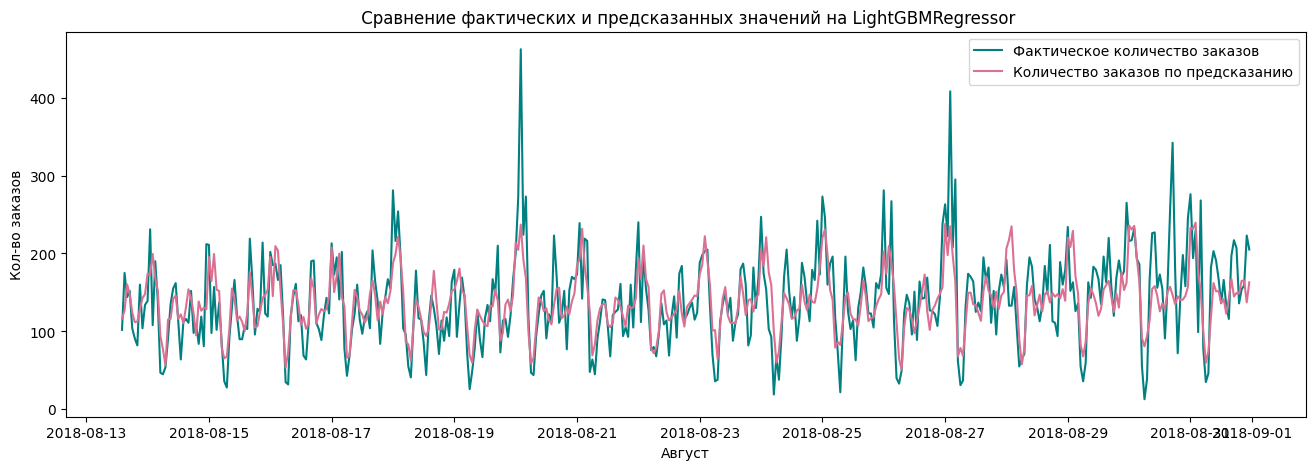

In [35]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(target_test.index, target_test, color='teal', label='Фактическое количество заказов')
ax.plot(target_test.index, predict_LGBMR, color='PaleVioletRed', label='Количество заказов по предсказанию')
plt.title(' Сравнение фактических и предсказанных значений на LightGBMRegressor')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

### CatBoostRegressor

In [38]:
predict_CBR = model_CBR_selection.predict(features_test)

rsme_CBR_test = mean_squared_error(target_test, predict_CBR) ** 0.5

print("RMSE на лучшей модели CatBoostRegressor на тестовой выборке:", rsme_CBR_test)

RMSE на лучшей модели CatBoostRegressor на тестовой выборке: 46.39119311600142


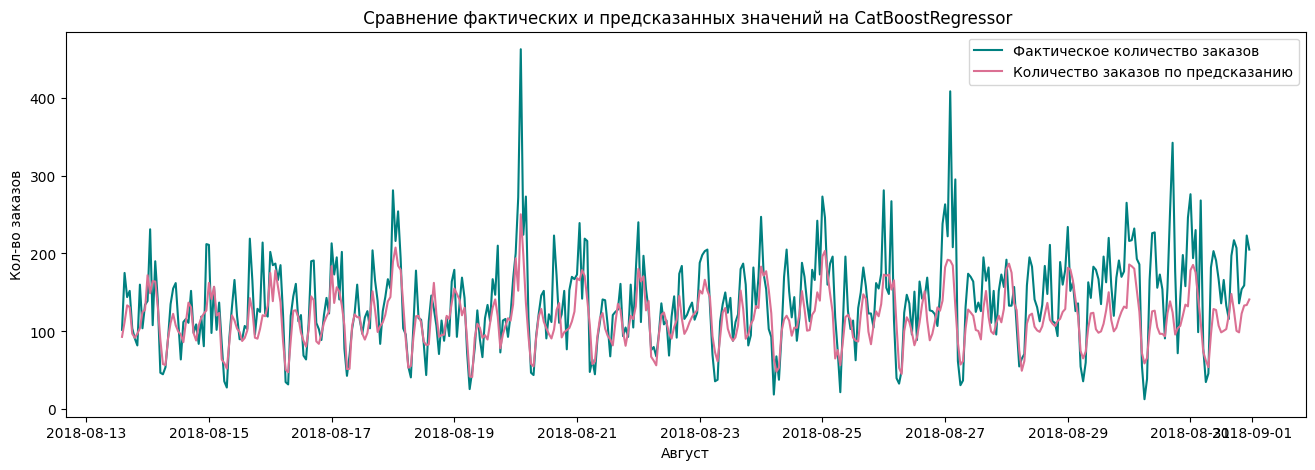

In [39]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(target_test.index, target_test, color='teal', label='Фактическое количество заказов')
ax.plot(target_test.index, predict_CBR, color='PaleVioletRed', label='Количество заказов по предсказанию')
plt.title(' Сравнение фактических и предсказанных значений на CatBoostRegressor')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

### LinearRegression

In [40]:
model_LR.fit(features_train, target_train)
predict_LR = model_LR.predict(features_test)
rmse_LR_test = mean_squared_error(target_test, predict_LR) ** 0.5
print ('RMSE на лучшей модели LinearRegression на тестовой выборке:', rmse_LR_test)

RMSE на лучшей модели LinearRegression на тестовой выборке: 44.7137265628387


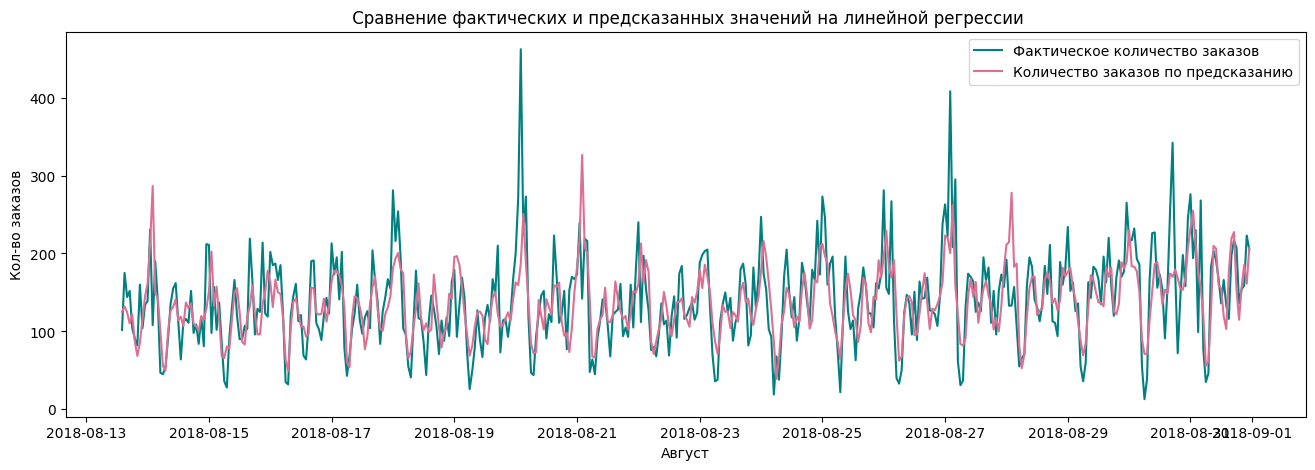

In [41]:

fig, ax = plt.subplots(figsize=(16,5))
ax.plot(target_test.index, target_test, color='teal', label='Фактическое количество заказов')
ax.plot(target_test.index, predict_LR, color='PaleVioletRed', label='Количество заказов по предсказанию')
plt.title(' Сравнение фактических и предсказанных значений на линейной регрессии')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()



### RandomForestRegressor

In [42]:


predict_RFR= model_RFR_selection.predict(features_test)
rmse_RFR_test = mean_squared_error(predict_RFR, target_test) ** 0.5
print ('RMSE на лучшей модели RandomForestRegressor на тестовой выборке:', rmse_RFR_test)

RMSE на лучшей модели RandomForestRegressor на тестовой выборке: 41.13222407135084


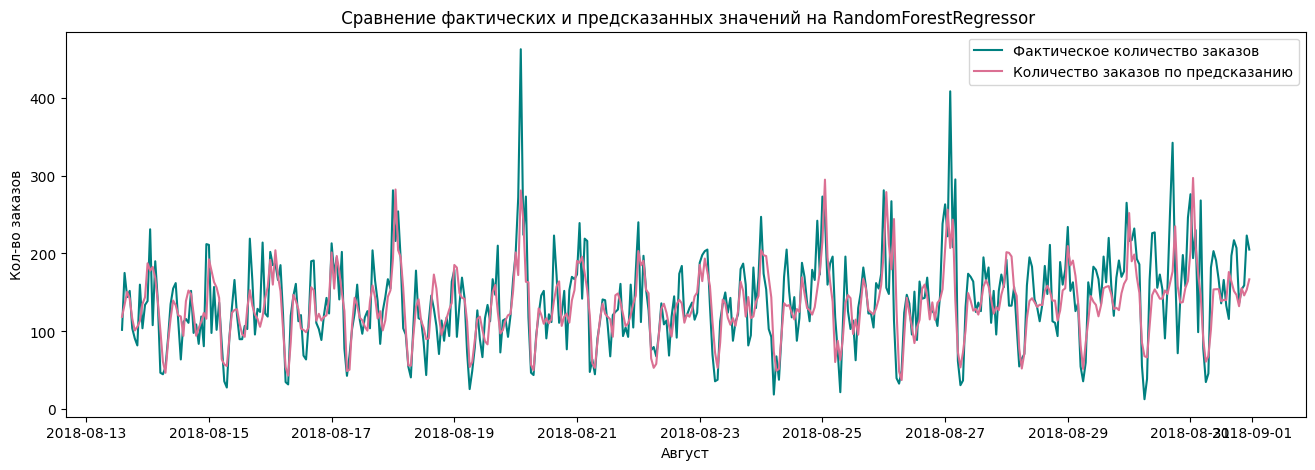

In [43]:
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(target_test.index, target_test, color='teal', label='Фактическое количество заказов')
ax.plot(target_test.index, predict_RFR, color='PaleVioletRed', label='Количество заказов по предсказанию')
plt.title(' Сравнение фактических и предсказанных значений на RandomForestRegressor')
plt.xlabel('Август')
plt.ylabel('Кол-во заказов')
plt.legend()
plt.show()

In [44]:
models = ['LightGBMRegressor',
          'CatBoostRegressor',
          'LinearRegression',
          'RandomForestRegressor']

df = {'RMSE':[rsme_LGBMR,
              rsme_CBR,
              rsme_LR,
              rsme_RFR]
}
control_metrics = pd.DataFrame(data=df, index=models)
control_metrics

,RMSE
LightGBMRegressor,25.269180
CatBoostRegressor,25.482204
LinearRegression,27.290113
RandomForestRegressor,25.615722


### Проверка на адекватность

Проверим на адекватность предыдущим значением ряда:

In [45]:

pred_dm_test = target_test.shift()
pred_dm_test.iloc[0] = target_train.iloc[-1]
rsme_dummy = mean_squared_error(target_test, pred_dm_test) ** 0.5
print ('RMSE с проверочным предсказанием :', rsme_dummy)

RMSE на модели DummyRegressor: 58.856486242815066


## Вывод:
1. Данные представляют собой информацию о заказах такси в аэропортах в период с 1 марта 2018г по 31 августа 2018г, всего 26496 строк
2. Данные расположены в хронологическом порядке
3. Пропуски, нулевые значения и дубликаты не обнаружены
4. Интересны выбросы в целевом признаке - но их удалять не будем, т к во временном ряду не должно быть пробелов, возможно большое количество заказов связано с каким-нибудь коллапсом с задержкой рейсов
5. Изменили тип данных в колонке 'datetime' с object на datetime64
6. Установили индекс таблицы равным колонке 'datetime'
7. Выполнили ресемплирование данных по одному часу
8. Изучили тренды, сезонности и остатки
9. Сформировали признаки. Год и месяц не будем использовать т к они не отражают нужные зависимости,
 max_lag = 24 (так как наблюдается выраженная сезонность в сутки),
rolling_mean_size = 168 (количество часов в неделю, так как наблюдается недельная сезонность)
10. Разделили данные на тренировочную и тестовую выборки в соотношении 9:1 (тестовая выборка 10% от исходных данных по условию задачи)
11. **Обучены 4 модели с подбором гиперпараметров: LightGBMRegressor, CatBoostRegressor, LinearRegression (с кросс-валидацией), RandomForestRegressor**
12. **Все модели прошли проверку на адекватность (RMSE с проверочным предсказанием: 58.856486242815066)**
13. **Получены результаты по контрольным метрикам, все модели удовлетворяют условию "значение метрики RMSE < 48":**
14. **Лучший результат на тренировочной выборке с кросс-валидацией у LightGBMRegressor:	25.269180**




|Модель |RMSE|
|-------|----|
|LightGBMRegressor|	25.269180|
|CatBoostRegressor|	25.482204|
|LinearRegression| 27.290113|
|RandomForestRegressor|	25.615722|

15. **На основании контрольных показателей можно рекомендовать заказчику модель**
 * **LightGBMRegressor с гиперпараметрами (num_leaves=10, learning_rate=0.1, n_estimators=200, random_state=12345)**
 * **RMSE на лучшей модели LightGBMRegressor на тестовой выборке с GLMMEncoder: 40.29710843604546**
